# 1.Giriş

ARMA modellerinin tutarlı ve etkin şekilde tahmini için uygulamada genellikle koşullu Maksimum Olabilirlik (ML - Maximum Likelihood) yöntemi kullanılır. MA kısmı olmayan pür AR(p) modellerinin tahmininde ise standart En Küçük Kareler (OLS) yöntemi uygulanabilir. Pür rassal şok serisi $\epsilon_{t}$ gözlenemediğinden MA modellerinin tahmininde OLS yöntemi uygulanamaz. Kalman filtresi ya da koşullu ML yöntemlerinin uygulanması gerekir.

# 2. Zaman Serilerinde Doğrusallık

Bir önceki yazıda doğrusal zaman serilerinden bahsetmiştik. Doğrusallık üzerine birkaç not daha ekleyip ARMA modelinin tahminlemesine başlayabiliriz.

Bir $\left\{X_{t}\right\}$ zaman serisi, aşağıdaki eşitliği sağlıyorsa, **doğrusal** olduğu söylenir:

$$
X_{t}=\sum_{k=-\infty}^{\infty} \beta_{k} Z_{t-k}
$$

burada $\beta_{k}$ katsayıları (en küçük) karelerin toplanırlığıdır, ve $\left\{Z_{t}\right\}$ serisi, sıfır ortalama ve $\sigma^{2}>0$ varyans ile bağımsız ve türdeş dağılımlıdır (independent, identically distributed - i.i.d). $\beta$ parametresinin, ölçek parametresi $\sigma$ ile karışmasından kaçınmak için $\beta_{0}=1$ olduğunu varsaymak işimize yarar.

## Zaman Serilerinde Doğrusallığın (Doğrusal Olmamanın) Testi: BDS Testi

Brock, Dechert, Scheinkman ve LeBaron (1996) tarafından önerilen BDS testi, bir seride zamana dayalı bağımlılık için bir portmanteau testidir. Doğrusal bağımlılık, doğrusal olmayan bağımlılık veya kaos dahil olmak üzere bağımsızlıktan çeşitli olası sapmalara karşı test etmek için kullanılabilir.

Test, kalıntıların bağımsız ve türdeş (i.i.d.) dağılmış olup olmadığını kontrol etmek için bir dizi tahmini kalıntıya uygulanabilir. Örneğin, bir ARMA modelinden gelen artıklar, lineer ARMA modeli takıldıktan sonra seride herhangi bir lineer olmayan bağımlılık olup olmadığını görmek için test edilebilir.

BDS testi iki kuyruklu bir testtir, BDS test istatistiği kritik değerlerden büyük veya küçükse boş hipotezi reddetmemiz gerekir (örneğin a=0.05 ise kritik değer = ±1.96).

Hipotez testinde genellikle $\alpha$ %5 anlamlılık düzeyi alınır. Boş ve alternatif hipotezle aşağıdaki gibi ifade edilir:

$H_{0}$: Seri doğrusal bağımlıdır

$H_{1}$: Seri doğrusal bağımlı değildir.

***Örnek: Logaritmik GSYH Serisinin Doğrusallığı***

Önceki yazıda görselleştirmesini yaptığımız, Türkiye GSYH'sinin doğrusal olup olmadığını, BDS testi ile tes edelim. Bunun için, `statsmodels` çerçevesi içindeli `bds` metodunu kullanacağız.

In [6]:
# gereksiz uyarıları gizlemek için
import warnings
warnings.filterwarnings("ignore")

# gerekli çerçevelerin içeri alınması
from pandas_datareader import wb
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import bds

# verinin düzenlenmesi
gsyh = wb.download(indicator='NY.GDP.PCAP.KD', country=['TR'], start=1960, end=2020).reset_index()
gsyh = gsyh.rename(columns={'NY.GDP.PCAP.KD':"gsyh"})
gsyh['log_gsyh'] = np.log(gsyh['gsyh'])
gsyh = gsyh.sort_values(by="year")

In [2]:
bds_testi = bds(gsyh.log_gsyh)
print(f"Test istatistiği: {bds_testi[0]}")
print(f"p-değeri        : {bds_testi[1]}")

Test istatistiği: 36.88254893179127
p-değeri        : 8.801183687448895e-298


p-değeri, 0.05'ten oldukça küçük olduğundan, serinin doğrusal olduğunu söyleyen boş hipotezi reddedebiliriz.

# 3.ARMA(p,q) Modelinin Koşullu ML Tahmini

ARMA modelinin gecikme değerleri $p$ ve $q$ biliniyorsa, önceki alt bölümlerdekine benzer șekilde koșullu log-olabilirlik fonksiyonu kolaylıkla türetilebilir. Bunun için $y$ 'nin $p$ bașlangıç değerine, $\epsilon_{t}$ 'nin de $q$ başlangıç değerine ihtiyaç duyulur. Pratikte genellikle $y_{t}$ 'nin ilk $p$ değeri bașlangıç koșulu olarak alınır. $\epsilon_{t}$ 'nin bașlangıç değerleri ise genellikle 0 kabul edilir. zamanındaki gözlenemeyen șoku

$$
\epsilon_{t}=y_{t}-c-\phi_{1} y_{t-1}-\ldots-\phi_{p} y_{t-p}-\theta_{1} \epsilon_{t-1}-\ldots-\theta_{q} \epsilon_{t-q}
$$

olarak yazarsak log-olabilirlik fonksiyonu așağıdaki gibi yazılabilir:

$$
\log L(\Theta)=-\frac{(T-p)}{2} \log (2 \pi)-\frac{(T-p)}{2} \log \left(\sigma^{2}\right)-\sum_{t=p+1}^{T} \frac{\epsilon_{t}^{2}}{2 \sigma^{2}}
$$

ARMA modelinin ML tahmini için aşağıdaki prosedür izlenebilir:

1. {$\epsilon_{t}$} nin bağımsız ve türdeş, $N\left(0, \sigma^{2}\right)$ dağılıma uyduğunu varsayılır.
2. $ARMA(p,q)$ modeli durum-uzay biçiminde ifade edilir.
3. Log-olabilirlik fonksiyonunun, tahmin-hata ayrıştırması uygulanır.
4. Son olarak aşağıdaki yöntemlerden herhangi bir tanesi ya da her ikisi uygulanır:
   * Sınırlı Bilgi Maksimum-Olabilirlik (Limited Information Maximum-Likelihood, LIML) Yöntemi
     - $\left\{X_{t}\right\}$ serisin ilk $p$ değerine kısıt konulur.
     - {$\epsilon_{t}$} nin ilk $q$ değerinin sıfır olduğu varsayılır.
   * Tam Bilgi Maksimum-Olabilirlik (Full Information Maximum-Likelihood, FIML) Yöntemi
     - Tam olabilirliği belirleyebilmek için ilk $p$ değerin durağan dağılımı kullanılır.

***Örnek: Güneş lekeleri verisi için ARMA Modelinin koşullu ML tahmini***

Bu örnek için `statsmodels` çerçevesinin `sunspots` verisini kullanacağız. ARMA modelini de aynı çerçevede `method` parametresini "mle" olarak belirleyerek gerçekleştirceğiz.

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA

Veri hakkında özet bilgi:

In [4]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



Veride 1700-2008 yılları için 309 gözlem ve tek değişken bulunuyor.

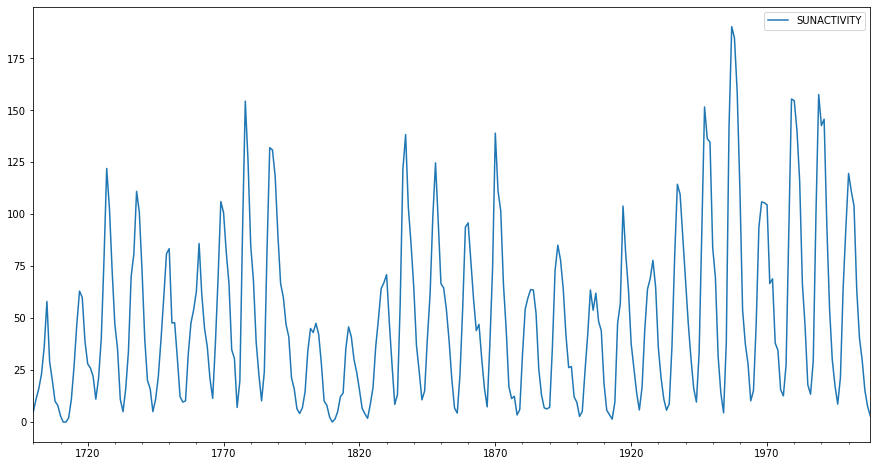

In [7]:
# verinin çalışma ortamına alınması
dta = sm.datasets.sunspots.load_pandas().data

# zaman indeksinin belirlenmesi
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

# verinin grafiği
dta.plot(figsize=(15,8));

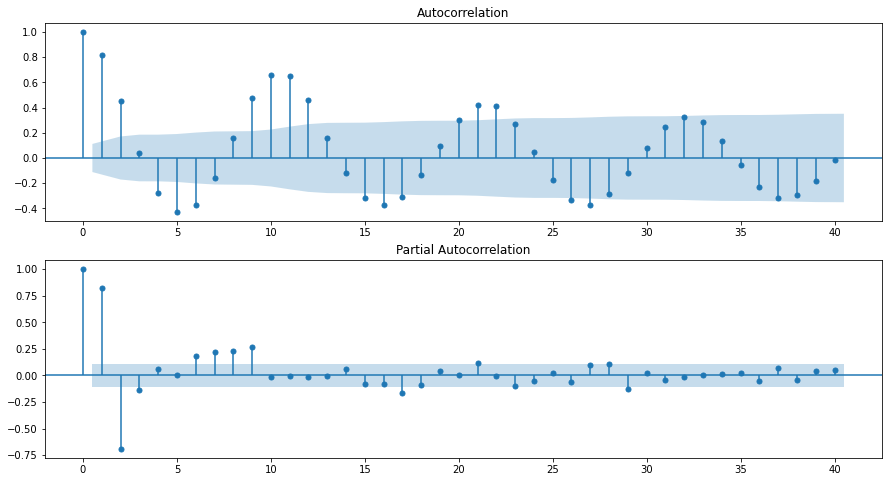

In [8]:
# acf ve pacf grafikleri
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

ARMA(3,0) modeli:

In [9]:
arma_mod30 = ARMA(dta, order=(3, 0, 0)).fit(method="mle")

Model çıktısı:

In [10]:
print(arma_mod30.summary())

                              ARMA Model Results                              
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                     ARMA(3, 0)   Log Likelihood               -1304.702
Method:                           mle   S.D. of innovations             16.435
Date:                Fri, 24 Dec 2021   AIC                           2619.404
Time:                        11:54:28   BIC                           2638.070
Sample:                    12-31-1700   HQIC                          2626.867
                         - 12-31-2008                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.7501      2.778     17.907      0.000      44.305      55.195
ar.L1.SUNACTIVITY     1.3008      0.056     23.079      0.000       1.190       1.411
ar.L2.SUNACTIVITY    -0.

# 4.Box-Jenkins Modelleme Yaklaşımı

ARMA modellerinin tahmin edilebilmesi için öncelikle $p$ ve $q$ 'nun belirlenmesi gerekir. Ayrica serinin kovaryans durağan olması şarttır. Uygulamada serilerin öncelikle durağan hale gelecek şekilde dönüștürülmesi gerekebilir. Bunun için genellikle $1 .$ fark alma, detrend etme ya da üstel yumușatma gibi yöntemler kullanılır.

B-J yaklaşımının adımları aşağıdaki gibi özetlenebilir:

1. Eğer gerekliyse serinin durağan olması için gerekli dönüştürmenin yapılması,
2. Dönüștürülmüș serinin ACF ve PACF'larını inceleyerek $p$ ve $q$ değerlerini belirleyerek aday ARMA( $p, q)$ modellerinin oluşturulması,
3. AR ve MA parametrelerini tahmin edilmesi,
4. Ceșitli diagnostik testler yardımıyla modeli uygunluğunun saptanması Box ve Jenkins açıklama gücü yüksek, küçük (az parametreli parsimonous, Occum's razor) modellerin tercih edilmesini önerir.

Örneklem kısmi otokorelasyon fonksiyonu (Partial Autocorrelation Function - PACF) ardıșik AR(p) modellerinin kurularak OLS yöntemiyle tahmin edilmesine dayanır. Bu șekilde gecikmeli değerlerin etkisi arındırildıktan sonraki etkiye bakılır. Örneğin

$$
\begin{aligned}
y_{t} &=\mu_{1}+\rho_{1,1} y_{t-1}+\varepsilon_{1 t} \\
y_{t} &=\mu_{2}+\rho_{2,1} y_{t-1}+\rho_{2,2} y_{t-2}+\varepsilon_{2 t} \\
y_{t} &=\mu_{3}+\rho_{3,1} y_{t-1}+\rho_{3,2} y_{t-2}+\rho_{3,3} y_{t-3}+\varepsilon_{3 t} \\
y_{t} &=\mu_{4}+\rho_{4,1} y_{t-1}+\rho_{4,2} y_{t-2}+\rho_{4,3} y_{t-3}+\rho_{4,4} y_{t-4}+\varepsilon_{4 t} \\
\vdots &=\vdots
\end{aligned}
$$

Birinci denklemden elde edilen katsayı tahmini, $\hat{\rho}_{1,1}$, birinci gecikmedeki örneklem PACF degeridir. Benzer șekilde, ikinci denklemden hesaplanan $\hat{\rho}_{2,2}$ katsayısı ikinci gecikmedeki PACF degeridir. Diğer gecikmelerdeki PACF değerleri benzer șekilde hesaplanabilir. Bu PACF degerlerinin gecikmeye göre grafiği çizilerek davranışına bakılabilir.

\begin{array}{|c|c|c|c|}
\hline & \operatorname{AR}(p) & \operatorname{MA}(p) & \operatorname{ARMA}(p, q) \\
\text { ACF } & \text { Üstel 0'a yaklașır } & q \text { 'dan sonra } 0 & \text { Üstel 0'a yaklașır }(>q) \\
\text { PACF } & p \text { 'den sonra 0 } & \text { Üstel 0'a yaklașır } & \text { Üstel 0'a yaklașır }(>p) \\
\hline
\end{array}

# 5.Mevsimsellik

Klasik zaman serisi ayrıștırmasında bir zaman serisinin dört bileșenden oluștuğu düșünülür:

$$
y_{t}=m_{t}+s_{t}+x_{t}
$$

Burada $m_{t}$ trend bileșenini, $s_{t}$ mevsim bileșenini ve $x_{t}$ düzensiz rassal șok bileșenini göstermektedir. Özellikle aylık, çeyreklik (3-aylık) ya da 6-aylık verilerde mevsimsel etkiler görülebilir. Mevsimsel davranıș genellikle önceden bilinir. Yılın aynı dönemlerinde benzer davranıșların olușması çevrimsel davranıșla karıștırımamalıdır. ARMA modellemesi yapılmadan önce verilerden mevsimsel etkiler arındırilabilir.

Bunun için uygulamada kullanılabilecek en basit yöntem kukla değișken regresyonudur.  Aylık veriler için 11 kukla değișken, çeyreklik veriler için ise 3 mevsimsel kukla değișken olușturularak serinin bu kuklalar üzerine regresyonu kurulur. Bu regresyondan elde edilen kalıntılar mevsimsel düzeltmesi yapılmıș seriler olarak düșünülebilir. Bunun yanı sıra seride belirgin bir trend varsa modele deterministik trend terimi eklenebilir.  Ancak, serinin stokastik trend içermesi durumunda birinci farklarının alınması uygundur. Mevsimsel farkların alınması da bașka bir yöntem olarak düșünülebilir. Hem olasılıksal trend hem de mevsimsel davranıș varsa birinci farkın mevsimsel farkı alınarak dönüștürme yapılabilir. 

***Örnek: Atmosferdeki CO2 Miktarı***

Buradaki veriler Cleveland, Cleveland, McRae, ve Terpenning (1990) çalışmasında kullanılan Ocak 1959 - Aralık 1987 dönemine ait aylık gözlemlerden oluşmaktadır.

In [11]:
# co2 verileri
co2 = [315.58, 316.39, 316.79, 317.82, 318.39, 318.22, 316.68, 315.01, 314.02, 313.55,
       315.02, 315.75, 316.52, 317.10, 317.79, 319.22, 320.08, 319.70, 318.27, 315.99,
       314.24, 314.05, 315.05, 316.23, 316.92, 317.76, 318.54, 319.49, 320.64, 319.85,
       318.70, 316.96, 315.17, 315.47, 316.19, 317.17, 318.12, 318.72, 319.79, 320.68,
       321.28, 320.89, 319.79, 317.56, 316.46, 315.59, 316.85, 317.87, 318.87, 319.25,
       320.13, 321.49, 322.34, 321.62, 319.85, 317.87, 316.36, 316.24, 317.13, 318.46,
       319.57, 320.23, 320.89, 321.54, 322.20, 321.90, 320.42, 318.60, 316.73, 317.15,
       317.94, 318.91, 319.73, 320.78, 321.23, 322.49, 322.59, 322.35, 321.61, 319.24,
       318.23, 317.76, 319.36, 319.50, 320.35, 321.40, 322.22, 323.45, 323.80, 323.50,
       322.16, 320.09, 318.26, 317.66, 319.47, 320.70, 322.06, 322.23, 322.78, 324.10,
       324.63, 323.79, 322.34, 320.73, 319.00, 318.99, 320.41, 321.68, 322.30, 322.89,
       323.59, 324.65, 325.30, 325.15, 323.88, 321.80, 319.99, 319.86, 320.88, 322.36,
       323.59, 324.23, 325.34, 326.33, 327.03, 326.24, 325.39, 323.16, 321.87, 321.31,
       322.34, 323.74, 324.61, 325.58, 326.55, 327.81, 327.82, 327.53, 326.29, 324.66,
       323.12, 323.09, 324.01, 325.10, 326.12, 326.62, 327.16, 327.94, 329.15, 328.79,
       327.53, 325.65, 323.60, 323.78, 325.13, 326.26, 326.93, 327.84, 327.96, 329.93,
       330.25, 329.24, 328.13, 326.42, 324.97, 325.29, 326.56, 327.73, 328.73, 329.70,
       330.46, 331.70, 332.66, 332.22, 331.02, 329.39, 327.58, 327.27, 328.30, 328.81,
       329.44, 330.89, 331.62, 332.85, 333.29, 332.44, 331.35, 329.58, 327.58, 327.55,
       328.56, 329.73, 330.45, 330.98, 331.63, 332.88, 333.63, 333.53, 331.90, 330.08,
       328.59, 328.31, 329.44, 330.64, 331.62, 332.45, 333.36, 334.46, 334.84, 334.29,
       333.04, 330.88, 329.23, 328.83, 330.18, 331.50, 332.80, 333.22, 334.54, 335.82,
       336.45, 335.97, 334.65, 332.40, 331.28, 330.73, 332.05, 333.54, 334.65, 335.06,
       336.32, 337.39, 337.66, 337.56, 336.24, 334.39, 332.43, 332.22, 333.61, 334.78,
       335.88, 336.43, 337.61, 338.53, 339.06, 338.92, 337.39, 335.72, 333.64, 333.65,
       335.07, 336.53, 337.82, 338.19, 339.89, 340.56, 341.22, 340.92, 339.26, 337.27,
       335.66, 335.54, 336.71, 337.79, 338.79, 340.06, 340.93, 342.02, 342.65, 341.80,
       340.01, 337.94, 336.17, 336.28, 337.76, 339.05, 340.18, 341.04, 342.16, 343.01,
       343.64, 342.91, 341.72, 339.52, 337.75, 337.68, 339.14, 340.37, 341.32, 342.45,
       343.05, 344.91, 345.77, 345.30, 343.98, 342.41, 339.89, 340.03, 341.19, 342.87,
       343.74, 344.55, 345.28, 347.00, 347.37, 346.74, 345.36, 343.19, 340.97, 341.20,
       342.76, 343.96, 344.82, 345.82, 347.24, 348.09, 348.66, 347.90, 346.27, 344.21,
       342.88, 342.58, 343.99, 345.31, 345.98, 346.72, 347.63, 349.24, 349.83, 349.10,
       347.52, 345.43, 344.48, 343.89, 345.29, 346.54, 347.66, 348.07, 349.12, 350.55,
       351.34, 350.80, 349.10, 347.54, 346.20, 346.20, 347.44, 348.67]

co2 = pd.Series(co2, index=pd.date_range('1-1-1959', periods=len(co2), freq='M'), name = 'CO2')
co2.describe()

count    348.000000
mean     330.123879
std       10.059747
min      313.550000
25%      321.302500
50%      328.820000
75%      338.002500
max      351.340000
Name: CO2, dtype: float64

Verinin grafiği:

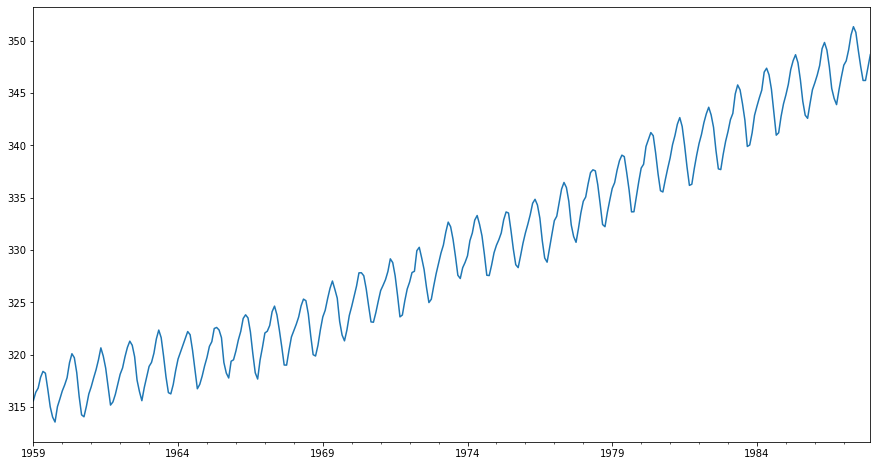

In [12]:
co2.plot(figsize=(15,8));

Mevsimsel ayrıştırma için `statsmodels` kütüphanesinden `seasonal_decompose` yöntemini kullanacağız. Mevsimsel ayrıştırma için 2 seçenek bulunuyor: toplamsal (additive) ya da çarpımsal (multiplicative) ayrıştırma. Doğru modeli seçmenin temel bir kuralı, trend ve mevsimsel değişimin zaman içinde nispeten sabit, başka bir deyişle doğrusal olup olmadığını grafiğimizde görmektir. Cevabınız evet ise, toplamsal modelini seçeceğiz. Aksi takdirde, trend ve mevsimsel değişim zamanla artarsa veya azalırsa, o zaman Çarpımsal modeli kullanırız.

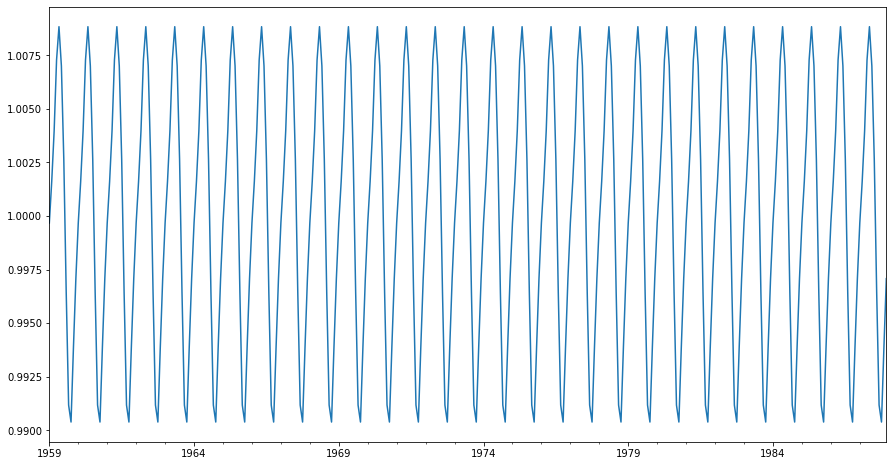

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# mevsimsel ayrıştırma
sonuç = seasonal_decompose(co2, model="multiplicative", period=12)

# mevsimsel bileşen
sonuç.seasonal.plot(figsize=(15,8));

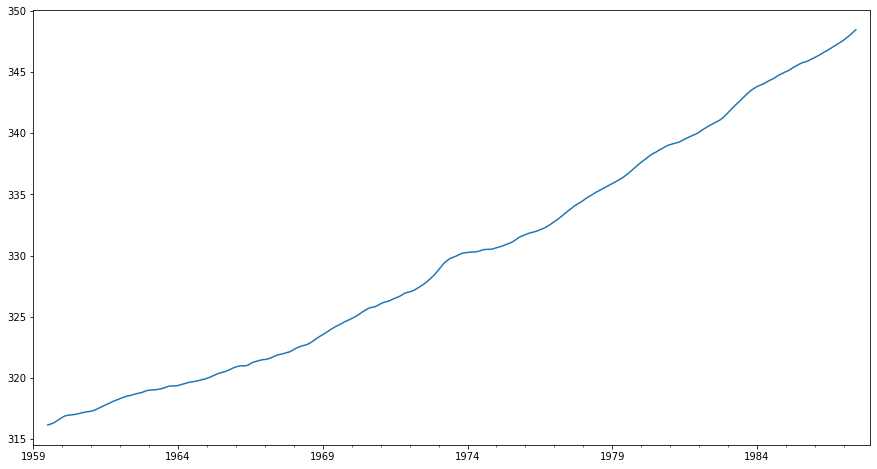

In [14]:
# trend bileşeni
sonuç.trend.plot(figsize=(15,8));

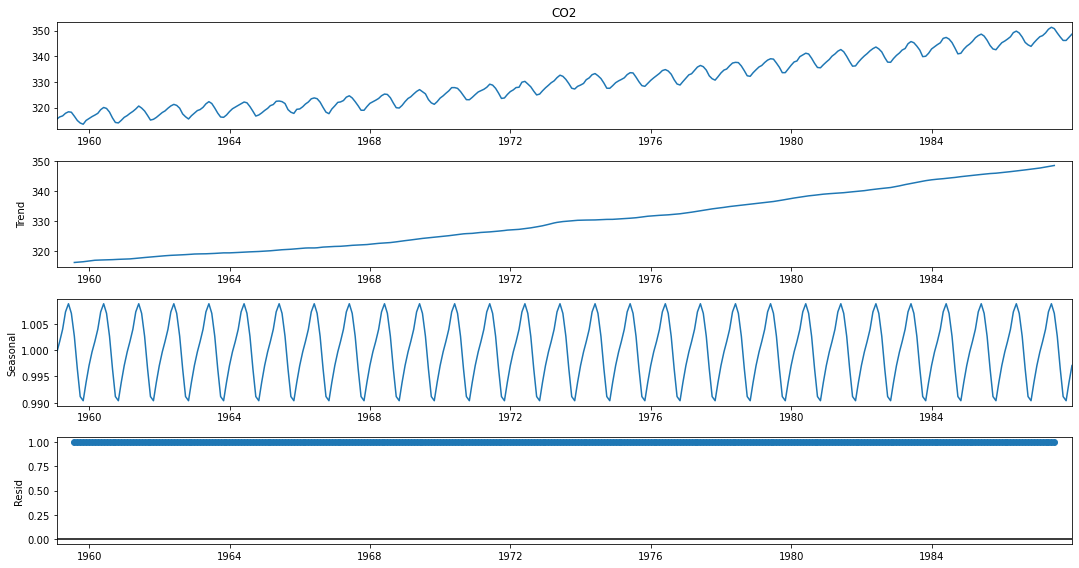

In [15]:
# serinin tüm bileşenleri
plt.rc("figure", figsize=(15,8))
sonuç.plot();

# 6. Model Seçimi

ARMA süreci için $(p, q)$ sırasının seçimi için istatistiksel model seçim kriterleri kullanılabilir:

1. Tüm $A R M A(p, q)$ modelleri $0 \leq p \leq p_{\max }$ ve $0 \leq q \leq q_{\max }$, ile, seçilen maksimum sıra sayıları ile tahmin edilir.
2. $\tilde{\sigma}^{2}(p, q)$, Gausyen/Normal varsayım altında ARMA inovasyonlarının varyansı $\sigma^{2}=\operatorname{Var}\left(\eta_{t}\right)$ nın en yüksek olabilirlik tahmini olsun.
3. Aşağıdaki kriterlerden birini en küçükleyen $(p,q)$ sırası seçilir:
  * Akaike Bilgi Kriteri:
    $$
    \operatorname{AlC}(p, q)=\log \left(\tilde{\sigma}^{2}(p, q)\right)+2 \frac{p+q}{n}
    $$
  * Bayes Bilgi Kriteri:
    $$
    B I C(p, q)=\log \left(\tilde{\sigma}^{2}(p, q)\right)+\log (n) \frac{p+q}{n}
    $$
  * Hannan-Quinn Bilgi Kriteri:
    $$
    H Q(p, q)=\log \left(\tilde{\sigma}^{2}(p, q)\right)+2 \log (\log (n)) \frac{p+q}{n}
    $$